# Project 2 

Data cleaning, linear decision tree model, and vizualisations

Authors: Nicole Blaustein, Lura Hayes, Jacqueline Chao, Ann Li, and Madelyn Khoury

## Summary 


Our question involves predicting the likelihood of a stroke for patients based on their recorded attributes. These predictive variables include age, average glucose level, body mass index, marriage status, gender, presence of heart disease, presence of hypertension, location of residence, smoking status, type of work, and whether the patient has had a previous stroke. To predict the likelihood of stroke according to the provided data, we decided to create a linear decision tree. Since there are many factors included in the dataset, the prediction of stroke becomes a multifaceted problem. A decision tree with linear models at each node allows us to minimize generalizations in our prediction model, for there is not a fixed value at the end of each node. We began working this problem by cleaning the provided data. This involved dealing with missing values by converting them to Nans, windsorizing variables with outliers, scaling skewed variables, and converting categorical variables into one hot encoded variables. Then, we made a fixed decision tree based on the X and Y training data. Typically, a good max depth for a decision tree is  log_2(number of attributes). Since we have 22 attributes, we completed the tree at a max depth of 4. Finally, we ran a linear regression on the samples found at each node. 

Overall, the performance of our model is not ideal. The R2 is -2.69 and the RMSE is .415. This performance could be due to potential overfitting since there are many variables being used to predict the likelihood of stroke. There is also a possibility that the model is trying to convert nonlinear relationships into linear relationships to make predictions. We decided to carry on with this model for the sake of time. While there are some problems with our model, we have still found some useful information regarding the likelihood of stroke. The most significant finding is that older people are more likely to have a stroke. Patients older than 50 are predicted to have more strokes, and patients older than 90 have the highest potential for strokes. It was also found that people with an above average body mass index (higher than 25) are more likely to have a stroke. The following paper will examine in depth how we cleaned the data, produced our model, and used visualizations to look at key findings for the model. 


## Outline of Data Cleaning Process and Reading in Cleaned Data Sets 

We used the testing and training data provided to us by our professor. This data includes information about 5,910 different patients with 4,087 entries in the training data and 1,023 entries in the training data. 

The variables include: 

* age : Patient age, numeric
* avg_glucose_level: Blood sugar levels, numeric
* bmi : Body mass index, numeric 
* ever_married: Ever married, dummy/character (Yes, No) 
* gender: Male, Female, or Other, character 
* heart_disease: Has heart disease, dummy 
* hypertension: Has hypertension, dummy 
* id : Study identification number
* Residence_type: Type of residence, dummy/character (Urban, Rural) 
* smoking_status: Former, never, or current smoker, categorical
* work_type: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (Private), Self-employed ( Self-employed ) 
* Stroke : Suffered a stroke in the sample period 

Reading and cleaning the data to prepare it for analysis was relatively straightforward. We began by converting the categorical variables into one hot encoded variables. This includes gender, ever_married, work_type, Residence_type, and smoking_status. This allows us to run linear models on variables without a numeric value. 

Then, we had to deal with missing values for bmi. We decided to create a dummy na column for bmi and convert all of the missing values to 0. The dummy column makes it clear which bmi values are missing (1). We used this approach because it is typically best for dealing with linear models. 
Next, we examined the numerical values for any outliers. Age had a box and whiskers plot without outliers, so we left it as it. However, bmi and avg_glucose_level contained many outliers that were above the maximum quartile. We windsorized both bmi and avg_glucose_level by computing the upper and lower whiskers of the plot using the IQR. Since bmi had a few missing values, we used np.nanpercentile to compute the 25 and 75 percentile ranges. This function computes the qth percentile of the data along the specified axis, while ignoring nan values. Afterwards, both variables had a standard box and whisker plot without outliers. 

The final step to cleaning this data was to look at the distribution of numerical variables to see if they needed transformation. BMI was very slightly skewed to the right. However, it was quite close to a normal distribution, so we left it as is. The histogram for avg_glucose_level was heavily skewed to the right, so it needed to be transformed. After attempting many log, sqrt, and arcsin transformations, we determined that a log transformation made the histogram appear the most evenly distributed. 

In [1]:
!git clone https://github.com/DS3001/Group4.git

fatal: destination path 'Group4' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np

In [3]:
try:
    df_train = pd.read_csv('./Group4/project_2/data/cleaned_training_data.csv')
    df_test = pd.read_csv('./Group4/project_2/data/cleaned_testing_data.csv')
except:
    df_train = pd.read_csv('data/cleaned_training_data.csv')
    df_test = pd.read_csv('data/cleaned_testing_data.csv')

In [4]:
df_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,log_avg_glucose_level,bmi_NA
0,36.0,0,0,65.87,32.2,0,0,1,0,1,...,0,0,0,1,0,1,0,0,4.187683,0
1,45.0,0,0,68.66,25.3,0,1,0,0,1,...,0,0,1,0,0,0,1,0,4.229167,0
2,58.0,0,0,170.93,30.7,0,0,1,1,0,...,1,0,1,0,1,0,0,0,5.141254,0
3,61.0,0,0,69.88,27.1,0,1,0,0,1,...,1,0,0,1,0,0,1,0,4.246779,0
4,78.0,0,0,103.86,30.6,0,1,0,1,0,...,0,0,0,1,1,0,0,0,4.643044,0


In [5]:
y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

## Results

### Decision Tree with Linear Models at Root Nodes

The following outlines the process for the creation of our linear decision tree model. 

#### Decision Tree Creation

First, I'll train the decision tree. I've read that a good max depth is about log_2(number of attributes), which is log_2(22), which is about 4.4. So, I'll try a max depth of 4.

In [6]:
from sklearn import tree
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [7]:
dtr_model = tree.DecisionTreeRegressor(max_depth=4)
dtr = dtr_model.fit(X_train, y_train)

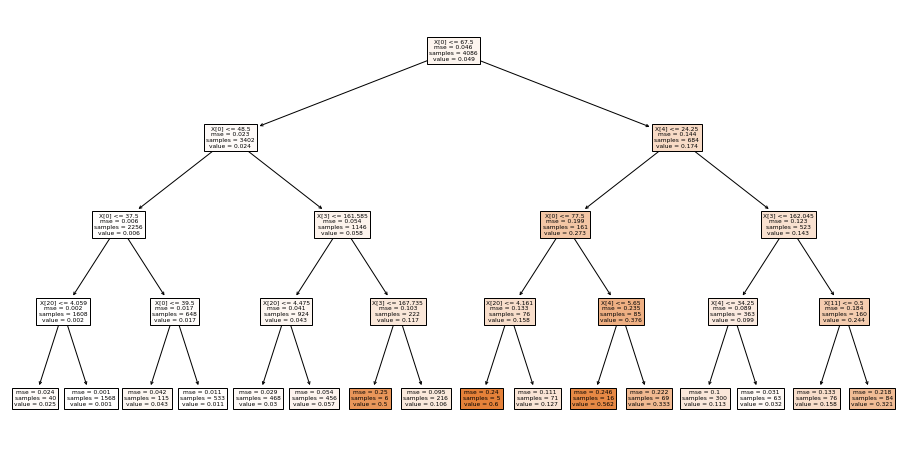

In [8]:
plt.figure(figsize=(16, 8))
tree.plot_tree(dtr,filled=True)
plt.show()

#### Linear Model Creation

Next, I'll train a linear model on the samples belonging to each leaf node. I can get the leaf node that each sample ends up at with the `.apply()` function. (I found this information [here](https://stackoverflow.com/questions/45398737/is-there-any-way-to-get-samples-under-each-leaf-of-a-decision-tree)).

In [9]:
training_leaf_nodes = dtr.apply(X_train)
leaf_node_values = np.unique(training_leaf_nodes)
print(leaf_node_values)

[ 4  5  7  8 11 12 14 15 19 20 22 23 26 27 29 30]


I'll make a list of DataFrames, where each DataFrame holds the samples that ended up at a particular leaf node; I'll call each of these groups a "subpopulation". I'll also make a corresponding list with the y values for each subpopulation.

In [10]:
def get_leaf_node_samples(leaf_node_value, samples, y, leaf_nodes_for_samples):
  indices_of_samples = (leaf_nodes_for_samples == leaf_node_value)
  node_samples = samples.loc[indices_of_samples].reset_index().drop("index", axis=1)
  node_y = y.loc[indices_of_samples].reset_index().drop("index", axis=1)["stroke"]
  return node_samples, node_y

In [11]:
subpopulation_dfs = list()
subpopulation_ys = list()
node_value_to_index = dict()

index = 0
for leaf_node_value in leaf_node_values:
  node_value_to_index[leaf_node_value] = index
  subpopulation, subpop_y = get_leaf_node_samples(leaf_node_value, X_train, y_train, training_leaf_nodes)
  subpopulation_dfs.append(subpopulation)
  subpopulation_ys.append(subpop_y)
  index += 1

Next I'll make the linear model for each subpopulation.

In [12]:
def train_linear_model(samples, y):
  reg = LinearRegression().fit(samples, y)
  return reg

In [13]:
def evaluate_linear_model(model, samples, y):
  print('R2: ', model.score(samples, y)) # R squared measure
  y_hat = model.predict(samples)
  N = len(y)
  print('RMSE: ', (np.sum( (y - y_hat)**2)/N )**.5, "\n" )   # R squared measure

In [14]:
linear_models = list()

for i in range(len(subpopulation_dfs)):
  model = train_linear_model(subpopulation_dfs[i], subpopulation_ys[i])
  evaluate_linear_model(model, subpopulation_dfs[i], subpopulation_ys[i])
  linear_models.append(model)

R2:  0.43141383248223186
RMSE:  0.117725476568352 

R2:  0.017537291157841528
RMSE:  0.035377151042120615 

R2:  0.18961117110526415
RMSE:  0.18358205510322825 

R2:  0.018087700559798248
RMSE:  0.10454182414017002 

R2:  0.040033576258185044
RMSE:  0.1669068315278123 

R2:  0.04239691884109642
RMSE:  0.22690748724651538 

R2:  1.0
RMSE:  1.6215845185301648e-15 

R2:  0.07892223562767298
RMSE:  0.2960308488338074 

R2:  1.0
RMSE:  1.807312143953211e-16 

R2:  0.27518044655749574
RMSE:  0.2832524670526873 

R2:  0.9725244053301189
RMSE:  0.082228779182176 

R2:  0.13427512729083968
RMSE:  0.43861521296744843 

R2:  0.017640092968395082
RMSE:  0.31419143137042765 

R2:  0.43533292693473946
RMSE:  0.13174544168347666 

R2:  0.2006049518550428
RMSE:  0.3260226285459082 

R2:  0.13894713114112267
RMSE:  0.4333660972003206 



#### Performance on Test Set

Finally, I'll examine how this combined model does on the test data.

The first step is to identify which leaf node each sample in the test set would be sorted into.

In [15]:
testing_leaf_nodes = dtr.apply(X_test)

Next, I will make a prediction for each test sample based on the linear model corresponding to that sample's leaf node. I'll concatenate all of these predictions into one full `y_hat` vector.

In [16]:
X_test.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,log_avg_glucose_level,bmi_NA
0,58.0,1,0,87.96,39.2,0,1,0,1,0,...,0,0,0,1,0,0,1,0,4.476882,0
1,8.0,0,0,110.89,17.6,1,0,1,0,0,...,0,0,0,1,1,0,0,0,4.708539,0
2,70.0,0,0,69.04,35.9,1,0,0,1,0,...,0,0,1,0,0,1,0,0,4.234686,0
3,47.0,0,0,210.95,50.1,1,0,0,1,0,...,0,0,0,1,1,0,0,0,5.351621,0
4,74.0,1,0,205.84,54.6,1,0,0,1,0,...,1,0,0,1,0,0,1,0,5.327099,0


In [17]:
print(type(X_test[0:1]))
print(type(X_test.iloc[0]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [18]:
test_y_hat = list()

for i in range(len(X_test)):
  sample_leaf_node = testing_leaf_nodes[i]
  sample_index = node_value_to_index[sample_leaf_node]
  node_model = linear_models[sample_index]
  sample_y = node_model.predict(X_test[i:i+1])
  test_y_hat.append(sample_y[0]) # there's only one prediction in each sample_y

In [19]:
y_hat = pd.Series(test_y_hat)

Finally, I'll calculate the performance of the combined models by comparing `y_hat` and `y_test`.

In [20]:
from sklearn.metrics import r2_score

In [21]:
final_r2 = r2_score(y_test, y_hat)
print('R2: ', final_r2)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5)

R2:  -2.676824949771073
RMSE:  0.41343026479039335


The R2 for this model is -2.696 and the RMSE is 0.415

### Important Visualizations for Analysis

In [22]:
df_train.columns[0]

'age'

Let us visualize the distribution of the important features as seen in our training data.

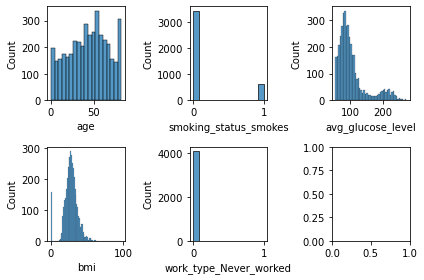

In [23]:
import seaborn as sns

fig, axs = plt.subplots(nrows = 2, ncols=3)

important_features = [0, 20, 3, 4, 11]
for ind, col_idx in enumerate(important_features):
    row = ind//3
    col = ind%3
    sns.histplot(df_train, x=df_train.columns[col_idx], ax=axs[row][col])

plt.tight_layout()

To get a better idea of how these features may be relevant for our model, we visualize the distribution of values for stroke patients and non-stroke patients separately.

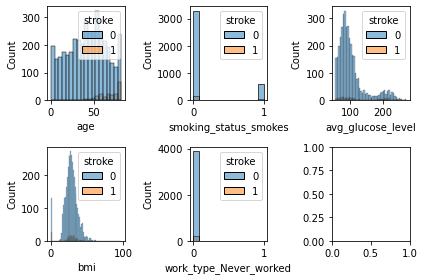

In [24]:
import seaborn as sns

fig, axs = plt.subplots(nrows = 2, ncols=3)

important_features = [0, 20, 3, 4, 11]
for ind, col_idx in enumerate(important_features):
    row = ind//3
    col = ind%3
    sns.histplot(df_train, x=df_train.columns[col_idx], ax=axs[row][col], hue="stroke")

plt.tight_layout()

Here we can see a few key findings from our model. Our most significant finding is that older age (above 50) is an indicator for a higher likelihood of stroke. Additionally, patients older than 90 have the highest likelihood of stroke. Smoking and diabetes do not appear to have a significant impact on likelihood of stroke. A patient with an above average bmi (above 25) has a higher likelihood of stroke. Smoking and work type do not appear to have a significant imapct, but our model predicts that people who do not smoke and have not worked are more likely to have to a stroke. While this does not reflect the reality of stroke prediction in the medical world, it is interesting to see how our model performs on different variables. 

The same information can also be presented as a kernel density plot, which emphasizes the shapes of our non-categorical features.

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


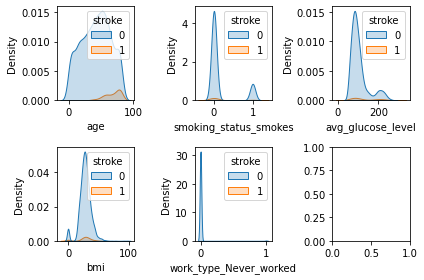

In [25]:
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3)

important_features = [0, 20, 3, 4, 11]
for ind, col_idx in enumerate(important_features):
    row = ind // 3
    col = ind % 3
    sns.kdeplot(data=df_train, x=df_train.columns[col_idx], ax=axs[row, col], hue="stroke", fill=True)

plt.tight_layout()
plt.show()

These visulizations reflect the findings found in the previous histogram. The lack of significant impact from work type and smoking is further emphasized in these graphs. 

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4086 entries, 0 to 4085
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4086 non-null   float64
 1   hypertension                    4086 non-null   int64  
 2   heart_disease                   4086 non-null   int64  
 3   avg_glucose_level               4086 non-null   float64
 4   bmi                             4086 non-null   float64
 5   stroke                          4086 non-null   int64  
 6   gender_Female                   4086 non-null   int64  
 7   gender_Male                     4086 non-null   int64  
 8   ever_married_No                 4086 non-null   int64  
 9   ever_married_Yes                4086 non-null   int64  
 10  work_type_Govt_job              4086 non-null   int64  
 11  work_type_Never_worked          4086 non-null   int64  
 12  work_type_Private               40

In [27]:
df_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,log_avg_glucose_level,bmi_NA
count,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,...,4086.00000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000
mean,43.328409,0.097895,0.056045,106.001263,27.799462,0.048703,0.586882,0.413118,0.342633,0.657367,...,0.16324,0.132648,0.497797,0.502203,0.303720,0.170827,0.368331,0.157122,4.591664,0.038913
std,22.532146,0.297209,0.230037,45.049641,9.509059,0.215273,0.492454,0.492454,0.474648,0.474648,...,0.36963,0.339235,0.500056,0.500056,0.459919,0.376404,0.482411,0.363960,0.360563,0.193412
min,0.080000,0.000000,0.000000,55.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.009513,0.000000
25%,26.000000,0.000000,0.000000,77.292500,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.347597,0.000000
50%,45.000000,0.000000,0.000000,91.990000,27.700000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.521680,0.000000
75%,61.000000,0.000000,0.000000,113.830000,32.800000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,4.734706,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.604846,1.000000


In [28]:
categorical_vars = [c for c in df_train.columns if df_train[c].dtype=='int64']
print("Number of entries for each categorical class")
for col in categorical_vars:
    print(f'{col}: {df_train[col].sum()}')

Number of entries for each categorical class
hypertension: 400
heart_disease: 229
stroke: 199
gender_Female: 2398
gender_Male: 1688
ever_married_No: 1400
ever_married_Yes: 2686
work_type_Govt_job: 534
work_type_Never_worked: 15
work_type_Private: 2328
work_type_Self-employed: 667
work_type_children: 542
Residence_type_Rural: 2034
Residence_type_Urban: 2052
smoking_status_Unknown: 1241
smoking_status_formerly smoked: 698
smoking_status_never smoked: 1505
smoking_status_smokes: 642
bmi_NA: 159


In order to gain a better understanding of the distribution of our data, we can look at larger versions of the previous histograms. This allows us to easily pick out key features of our training data. 

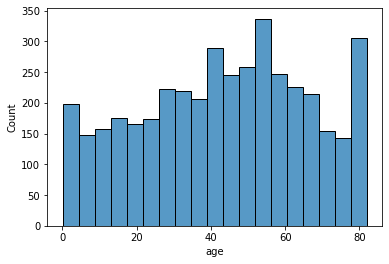

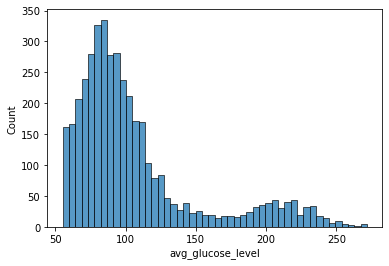

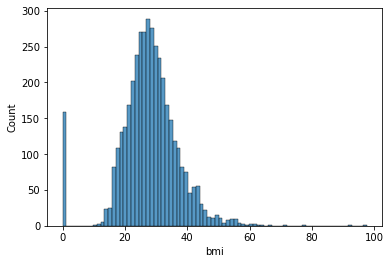

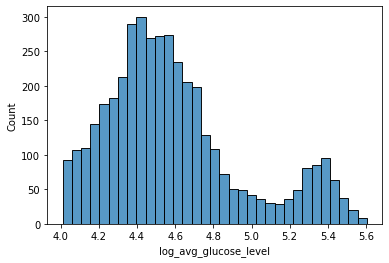

In [29]:
numerical_vars = [c for c in df_train.columns if df_train[c].dtype=='float64']
for col in numerical_vars:
    sns.histplot(df_train, x=col)
    plt.show()

Here, we can see the nans for bmi very clearly, and the impact of the log transformation on average glucose level. Since the average glucose level for adults without diabetes is 70 to 100, it can be assumed that the vast majority of patients in this data set are not diabetic. Age is relatively evenly distributed, but the uptick in 80+ patients should be noted. 

Next, we can visualize the outputs for the model. We have included both a histogram and a kernel density plot. 

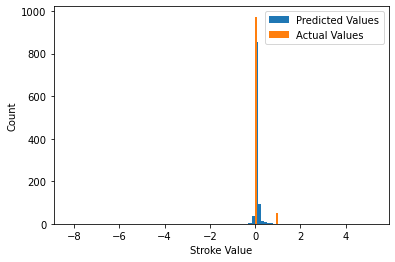

In [30]:
plt.hist(y_hat, bins=100, label="Predicted Values")
plt.hist(y_test, label="Actual Values")
plt.xlabel("Stroke Value")
plt.ylabel("Count")
plt.legend()

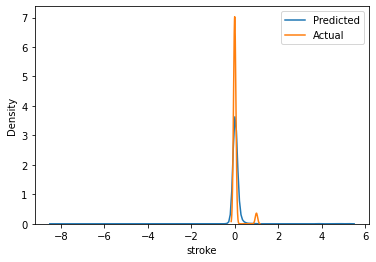

In [31]:
import seaborn as sns
sns.kdeplot(data=y_hat, label="Predicted")
sns.kdeplot(data=y_test, label="Actual")
plt.legend()

## Conclusion: Summary, Defense, and Suggestions for Future Research 

While our model did not perform as accurately as possible, it still gave us some valuable insight on the factors that influence stroke. Age had a significant impact on the likelihood of stroke, and older patients are more susceptible. Additionally, people with an above average bmi (higher than 25) were more likely to experience a stroke. Smoking, diabetes, and many of the categorical variables were not found to have a significant impact on the likelihood of a stroke. 

According to this scatterplot, our model did a better job at predicting a stroke that actually happened, and it did worse with patients who did not have a stroke. This means it is more likely to predict a stroke that did not happen than to miss a stroke that did happen. 


Text(0.5, 0, 'Predicted Stroke Value')

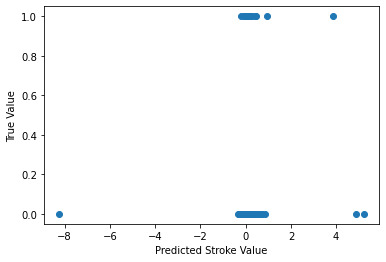

In [32]:
plt.scatter(y_hat, y_test)
plt.ylabel("True Value")
plt.xlabel("Predicted Stroke Value")

This project was completed by UVA students under the school of data science, and it should not be used for medical purposes. The overfitting of our model could cause problematic medical practices if it used for patient care. Our most significant finding indicates that people over 50 are more likely to experience a stroke, and people aged 90-100 have the highest risk. This coincides with the [CDC’s guidelines](https://www.cdc.gov/stroke/risk_factors.htm#:~:text=Family%20Health%20Portrait.-,Age,65%20years%20also%20have%20strokes.) for risk of stroke. According to the CDC, the chance of stroke doubles every 10 years after the age of 55. 

The allotted time frame for this project did not allow us to create the perfect model for prediction of stroke, but we have some suggestions for further methods to use outside of this project. Something that might be beneficial in the future is to use K means clustering to cluster the data and apply a linear model to each cluster. This might be more helpful to researchers because it creates clusters of similar data points and finds trends amongst these groups. 